# Reversal learning task

Probability ratings will be used to derive both model-free and model-based parameters that will describe the quality of learning

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

import theano
import theano.tensor as tt

In [2]:
glober = '/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_*_RV/ETLearning_*.csv'
db = pd.DataFrame()

for sub in glob(glober):
    try:
        temp = pd.read_csv(sub)
        temp['sub']= sub.split("_")[2]
        #temp.rating.replace(o, np.nan) 
        temp['CSp'] = temp.rectOri[2]
            
        db = db.append(temp)
    except:
        print(sub)



In [3]:
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='scans')
age = age.iloc[:,1:8:6]
age.rename(columns={age.columns[0]: "sub" }, inplace = True)
age['sub'] = age['sub'].map(lambda x: x.lstrip('AG_'))
db = db.merge(age, left_on='sub', right_on='sub')

In [4]:
db['rating_clean'] = db.rating
db['rating_clean'] = db.rating_clean.replace(0, np.nan)
fig1 = db[db.rating!=0]

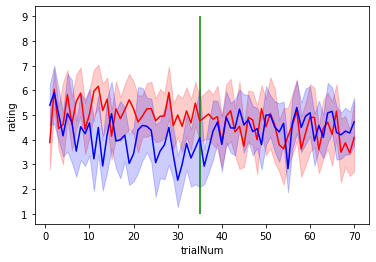

In [5]:
sns.lineplot(x='trialNum',y='rating', data=db[(db.rectOri==db.CSp)], color ='red')
sns.lineplot(x='trialNum',y='rating', data=db[(db.rectOri!=db.CSp)], color='blue')
plt.vlines(x=35, ymin=1, ymax=9, colors='green')

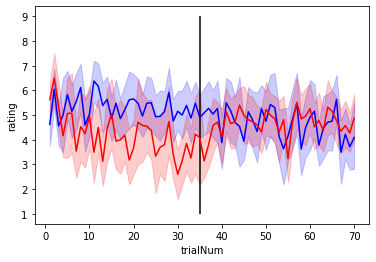

In [6]:
sns.lineplot(x='trialNum',y='rating', data=fig1[(fig1.rectOri==fig1.CSp)], color='blue')
sns.lineplot(x='trialNum',y='rating', data=fig1[(fig1.rectOri!=fig1.CSp)], color='red')
plt.vlines(x=35, ymin=1, ymax=9, colors='black')

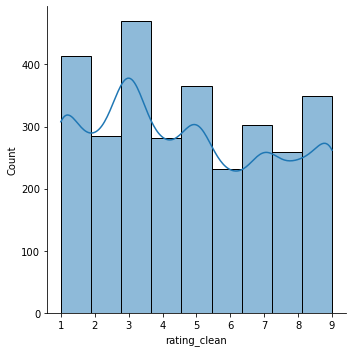

In [7]:
sns.displot(db.rating_clean, kde=True, bins=9)

## Model free analysis

1. Acquisition strength (ACQ) = the difference between the mean ratings of CS+ and CS− in the second half of the acquisition stage (late acquisition)

2. change in rating of CS+ (ΔCS+) between late acquisition and late reversal

3. change in rating of CS- (ΔCS-) between late reversal and late acquisition


In [47]:
subs = db['sub'].unique()

model_free= pd.DataFrame()

for sub in subs:
    df = db[db['sub'] == sub]
    df = df[df.rectValue == 0].reset_index()
    trials = []
    for i in range(len(df)):
    
        temp = df[:i+1]
        trials.append(len(temp[temp['rectOri']== temp['rectOri'][i]]))

    df['trials'] = trials
    
    
    CSpA = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] < 15) & (df['trials'] > 7)]['rating_clean'])
    CSmA = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] < 15) & (df['trials'] > 7)]['rating_clean'])
    
    CSpeR = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] < 21) & (df['trials'] > 15)]['rating_clean'])
    CSmeR = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] < 21) & (df['trials'] > 15)]['rating_clean'])

    CSpR = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] > 21)]['rating_clean'])
    CSmR = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] > 21)]['rating_clean'])

    ACQ = CSpA - CSmA
    dCSp = CSpA - CSpR 
    dCSm = CSmR - CSmA
    
    temp = pd.DataFrame({'sub':[sub], 'ACQ':[ACQ], 'dCSp':[dCSp], 'dCSm':[dCSm], 
                         'age':[df.Age[0]], 'CSpR':[CSpR], 'CSpeR': [CSpeR],
                        'CSmeR':[CSmeR], 'CSmR':[CSmR]})
    model_free = model_free.append(temp)

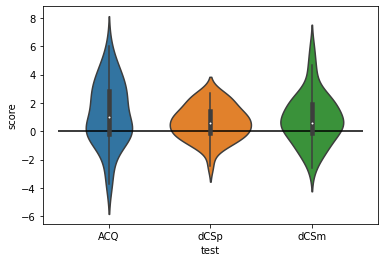

In [48]:
fig2 = pd.melt(model_free, id_vars='sub', value_vars=['ACQ', 'dCSp', 'dCSm'], value_name='score', var_name = 'test')
sns.violinplot(x = 'test', y='score', data=fig2)
plt.hlines(y=0,xmin=-0.5,xmax=2.5, color='black')

<AxesSubplot:xlabel='age', ylabel='dCSm'>

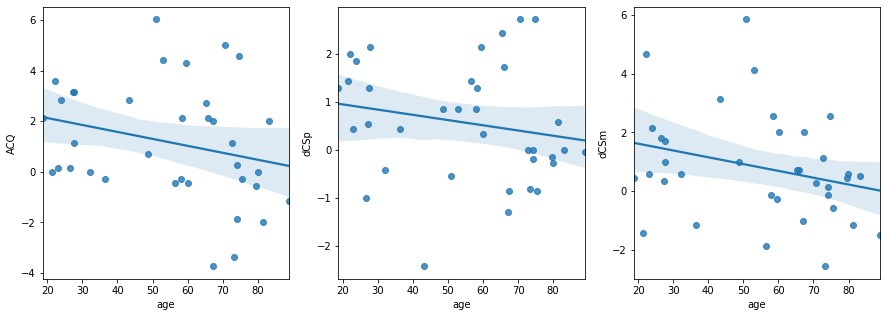

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.regplot(y = 'ACQ',  x = 'age', data=model_free, ax=axes[0])
sns.regplot(y = 'dCSp', x = 'age', data=model_free, ax=axes[1])
sns.regplot(y = 'dCSm', x = 'age', data=model_free, ax=axes[2])

<AxesSubplot:xlabel='CSmeR', ylabel='CSmR'>

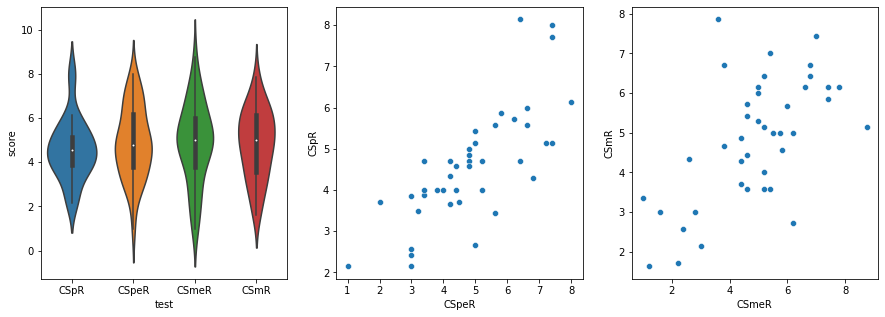

In [61]:
fig3 = pd.melt(model_free, id_vars='sub', value_vars=['CSpR', 'CSpeR', 'CSmeR', 'CSmR'], value_name='score', var_name = 'test')
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ident = [0.0, 9.0]

sns.violinplot(x = 'test', y = 'score', data = fig3, ax=axes[0])
sns.scatterplot(x = 'CSpeR', y = 'CSpR', data = model_free, ax = axes[1])
sns.scatterplot(x = 'CSmeR', y = 'CSmR', data = model_free, ax = axes[2])
#plt.plot(ident,ident)